In [ ]:
%pip install pandas seaborn scipy

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from scipy import stats
import numpy as np
import math

pd.options.mode.copy_on_write = True

In [3]:
df = pd.read_csv("2024-12-10 _ Benchmark Results - Results.csv")
# df = pd.read_csv("2024-12-03 _ Benchmark Results (Nightly Runs) - Results.csv")
df = df[df['Workload'] != 'vectorsearch']
df

,Workload,Category,Operation,Comparison\nES/OS,Unnamed: 4,OS version,OS SubType,OS: STDEV 50,OS: STDEV 90,OS: Average 50,...,OS: RSD 90,Unnamed: 13,ES version,ES SubType,ES: STDEV 50,ES: STDEV 90,ES: Average 50,ES: Average 90,ES: RSD 50,ES: RSD 90
0,big5,Sorting,asc_sort_timestamp,3.793,NaN,2.16.0,NaN,2.809,4.478,5.549,...,0.736,NaN,8.15.4,NaN,1.884,0.451,22.401,23.089,0.084,0.020
1,big5,Sorting,asc_sort_timestamp_can_match_shortcut,3.231,NaN,2.16.0,NaN,1.883,3.534,5.339,...,0.601,NaN,8.15.4,NaN,1.515,0.332,18.454,19.006,0.082,0.017
2,big5,Sorting,asc_sort_timestamp_no_can_match_shortcut,3.242,NaN,2.16.0,NaN,2.317,3.483,5.46,...,0.594,NaN,8.15.4,NaN,1.346,0.364,18.489,19.014,0.073,0.019
3,big5,Sorting,asc_sort_with_after_timestamp,2.131,NaN,2.16.0,NaN,32.873,47.213,182.592,...,0.246,NaN,8.15.4,NaN,45.584,40.504,396.521,409.064,0.115,0.099
4,big5,Term Aggregations,cardinality-agg-high,0.311,NaN,2.16.0,NaN,228.837,63.496,"2,346.409",...,0.026,NaN,8.15.4,NaN,25.905,26.620,725.015,761.475,0.036,0.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,pmc,Aggregation,articles_monthly_agg_uncached,1.06,NaN,2.18.0,NaN,0.385,0.33,5.7,...,0.053,NaN,8.15.4,NaN,0.307,0.244,6.272,6.606,0.049,0.037
290,pmc,General Operations,default,0.792,NaN,2.18.0,NaN,0.593,0.738,3.019,...,0.210,NaN,8.15.4,NaN,0.212,0.291,2.475,2.782,0.086,0.104
291,pmc,Text Querying,phrase,0.873,NaN,2.18.0,NaN,0.553,0.753,3.32,...,0.195,NaN,8.15.4,NaN,0.203,0.263,3.028,3.369,0.067,0.078
292,pmc,General Operations,scroll,0.407,NaN,2.18.0,NaN,170.02,271.215,489.241,...,0.437,NaN,8.15.4,NaN,15.6,34.600,238.801,252.598,0.065,0.137


In [4]:
os_df = df[[
    'Workload',
    'Category',
    'Operation',
    'OS version',
    'OS: Average 90'
]]
os_df = os_df.drop_duplicates()

In [5]:
os_216_df = os_df[os_df['OS version'] == "2.16.0"]
os_218_df = os_df[os_df['OS version'] == '2.18.0']

In [6]:
import pandas as pd
import numpy as np

# Convert performance columns to numeric type first
os_216_df['OS: Average 90'] = pd.to_numeric(os_216_df['OS: Average 90'].astype(str).str.replace(',', ''))
os_218_df['OS: Average 90'] = pd.to_numeric(os_218_df['OS: Average 90'].astype(str).str.replace(',', ''))

# Function to calculate percentage change (negative means faster, positive means slower)
def calculate_change(old_value, new_value):
    return ((new_value - old_value) / old_value) * 100

# Create lists to store our comparisons
comparisons = []

# Get unique workload-operations in both versions
for _, row_216 in os_216_df.iterrows():
    workload = row_216['Workload']
    operation = row_216['Operation']
    category = row_216['Category']
    
    # Find matching row in 2.18.0
    matching_218 = os_218_df[
        (os_218_df['Workload'] == workload) & 
        (os_218_df['Operation'] == operation)
    ]
    
    if not matching_218.empty:
        old_perf = row_216['OS: Average 90']
        new_perf = matching_218.iloc[0]['OS: Average 90']
        pct_change = calculate_change(old_perf, new_perf)
        
        comparisons.append({
            'Workload': workload,
            'Category': category,
            'Operation': operation,
            '2.16.0_time': old_perf,
            '2.18.0_time': new_perf,
            'change_percent': pct_change
        })

# Convert to DataFrame and sort by percentage change
results_df = pd.DataFrame(comparisons)
results_df = results_df.sort_values('change_percent', ascending=True)

# Calculate summary statistics
total_comparisons = len(results_df)
faster_count = len(results_df[results_df['change_percent'] < -5])
slower_count = len(results_df[results_df['change_percent'] > 5])
similar_count = len(results_df[abs(results_df['change_percent']) <= 5])

# Print high-level summary
print("\nPERFORMANCE COMPARISON SUMMARY (2.16.0 → 2.18.0)")
print("Comparison performed by looking at p90th")
print("============================================")
print(f"Total operations compared: {total_comparisons}")
print(f"Operations faster in 2.18.0: {faster_count} ({faster_count/total_comparisons*100:.1f}%)")
print(f"Operations slower in 2.18.0: {slower_count} ({slower_count/total_comparisons*100:.1f}%)")
print(f"Operations with similar performance: {similar_count} ({similar_count/total_comparisons*100:.1f}%)")

if faster_count > 0:
    print(f"\nBiggest improvement: {-results_df['change_percent'].min():.1f}% faster")
    print(f"Average improvement among faster operations: {-results_df[results_df['change_percent'] < -5]['change_percent'].mean():.1f}%")
if slower_count > 0:
    print(f"Biggest regression: {results_df['change_percent'].max():.1f}% slower")
    print(f"Average regression among slower operations: {results_df[results_df['change_percent'] > 5]['change_percent'].mean():.1f}%")


PERFORMANCE COMPARISON SUMMARY (2.16.0 → 2.18.0)
Comparison performed by looking at p90th
Total operations compared: 98
Operations faster in 2.18.0: 18 (18.4%)
Operations slower in 2.18.0: 20 (20.4%)
Operations with similar performance: 60 (61.2%)

Biggest improvement: 99.0% faster
Average improvement among faster operations: 40.0%
Biggest regression: 1028.7% slower
Average regression among slower operations: 105.5%


In [7]:
old_comparisons = comparisons
pd.DataFrame(old_comparisons)

,Workload,Category,Operation,2.16.0_time,2.18.0_time,change_percent
0,big5,Sorting,asc_sort_timestamp,6.088,5.036,-17.279895
1,big5,Sorting,asc_sort_timestamp_can_match_shortcut,5.882,5.226,-11.152669
2,big5,Sorting,asc_sort_timestamp_no_can_match_shortcut,5.865,5.214,-11.099744
3,big5,Sorting,asc_sort_with_after_timestamp,191.953,186.917,-2.623559
4,big5,Term Aggregations,cardinality-agg-high,2445.150,2334.328,-4.532319
...,...,...,...,...,...,...
93,pmc,Aggregation,articles_monthly_agg_uncached,5.869,6.234,6.219117
94,pmc,General Operations,default,2.761,3.511,27.164071
95,pmc,Text Querying,phrase,3.344,3.860,15.430622
96,pmc,General Operations,scroll,366.088,621.054,69.646096


In [8]:
new_comparisons = comparisons
pd.DataFrame(new_comparisons)

,Workload,Category,Operation,2.16.0_time,2.18.0_time,change_percent
0,big5,Sorting,asc_sort_timestamp,6.088,5.036,-17.279895
1,big5,Sorting,asc_sort_timestamp_can_match_shortcut,5.882,5.226,-11.152669
2,big5,Sorting,asc_sort_timestamp_no_can_match_shortcut,5.865,5.214,-11.099744
3,big5,Sorting,asc_sort_with_after_timestamp,191.953,186.917,-2.623559
4,big5,Term Aggregations,cardinality-agg-high,2445.150,2334.328,-4.532319
...,...,...,...,...,...,...
93,pmc,Aggregation,articles_monthly_agg_uncached,5.869,6.234,6.219117
94,pmc,General Operations,default,2.761,3.511,27.164071
95,pmc,Text Querying,phrase,3.344,3.860,15.430622
96,pmc,General Operations,scroll,366.088,621.054,69.646096


In [9]:
def print_details(df, s, visualize=True):
    # Print textual details
    for _, row in df.iterrows():
        print(f"\nWorkload: {row['Workload']}")
        print(f"Category: {row['Category']}")
        print(f"Operation: {row['Operation']}")
        print(f"Time change: {row['2.16.0_time']:.3f}ms → {row['2.18.0_time']:.3f}ms")
        print(f"Improvement: {-row['change_percent']:.1f}% {s}")
    
    # Create visualizations if requested
    if visualize:
        # Calculate grid dimensions
        n_plots = len(df)
        n_cols = 3  # We can adjust this
        n_rows = math.ceil(n_plots / n_cols)
        
        # Create figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        fig.suptitle(f'Performance Comparisons: OS 2.16.0 vs 2.18.0 ({s})', y=1.02)
        
        # Flatten axes array for easier iteration
        axes_flat = axes.flatten() if n_plots > 1 else [axes]
        
        # Create a bar chart for each operation
        for idx, (_, row) in enumerate(df.iterrows()):
            ax = axes_flat[idx]
            
            # Create data for this specific comparison
            versions = ['2.16.0', '2.18.0']
            times = [row['2.16.0_time'], row['2.18.0_time']]
            
            # Create bar chart
            bars = ax.bar(versions, times)
            
            # Add percentage change annotation
            pct_change = row['change_percent']
            color = 'green' if pct_change < 0 else 'red'
            ax.text(0.5, max(times)*1.1, 
                    f"Change: {pct_change:+.1f}%",
                    ha='center', color=color)
            
            # Add title and labels
            ax.set_title(f"{row['Workload']}\n{row['Operation']}", pad=20)
            ax.set_ylabel('Time (ms)')
            
            # Color bars based on performance change
            bars[1].set_color('green' if pct_change < 0 else 'red')
            bars[0].set_color('blue')
            
            # Add value labels on bars
            for i, v in enumerate(times):
                ax.text(i, v, f'{v:.1f}', ha='center', va='bottom')
        
        # Remove any unused subplots
        for idx in range(n_plots, len(axes_flat)):
            fig.delaxes(axes_flat[idx])
        
        plt.tight_layout()
        plt.show()


DETAILED BREAKDOWN

FASTER in 2.18.0:
------------------------------------------

Workload: big5
Category: Date Histogram
Operation: composite-date_histogram-daily
Time change: 114.405ms → 1.118ms
Improvement: 99.0% faster

Workload: big5
Category: Date Histogram
Operation: date_histogram_hourly_agg
Time change: 101.180ms → 4.814ms
Improvement: 95.2% faster

Workload: big5
Category: Term Aggregations
Operation: keyword-terms-low-cardinality
Time change: 255.204ms → 20.932ms
Improvement: 91.8% faster

Workload: big5
Category: Term Aggregations
Operation: keyword-terms
Time change: 261.245ms → 34.436ms
Improvement: 86.8% faster

Workload: big5
Category: Date Histogram
Operation: date_histogram_minute_agg
Time change: 117.219ms → 33.554ms
Improvement: 71.4% faster

Workload: big5
Category: Sorting
Operation: sort_numeric_asc
Time change: 9.989ms → 3.742ms
Improvement: 62.5% faster

Workload: big5
Category: Sorting
Operation: sort_numeric_desc
Time change: 9.358ms → 4.376ms
Improvement: 5

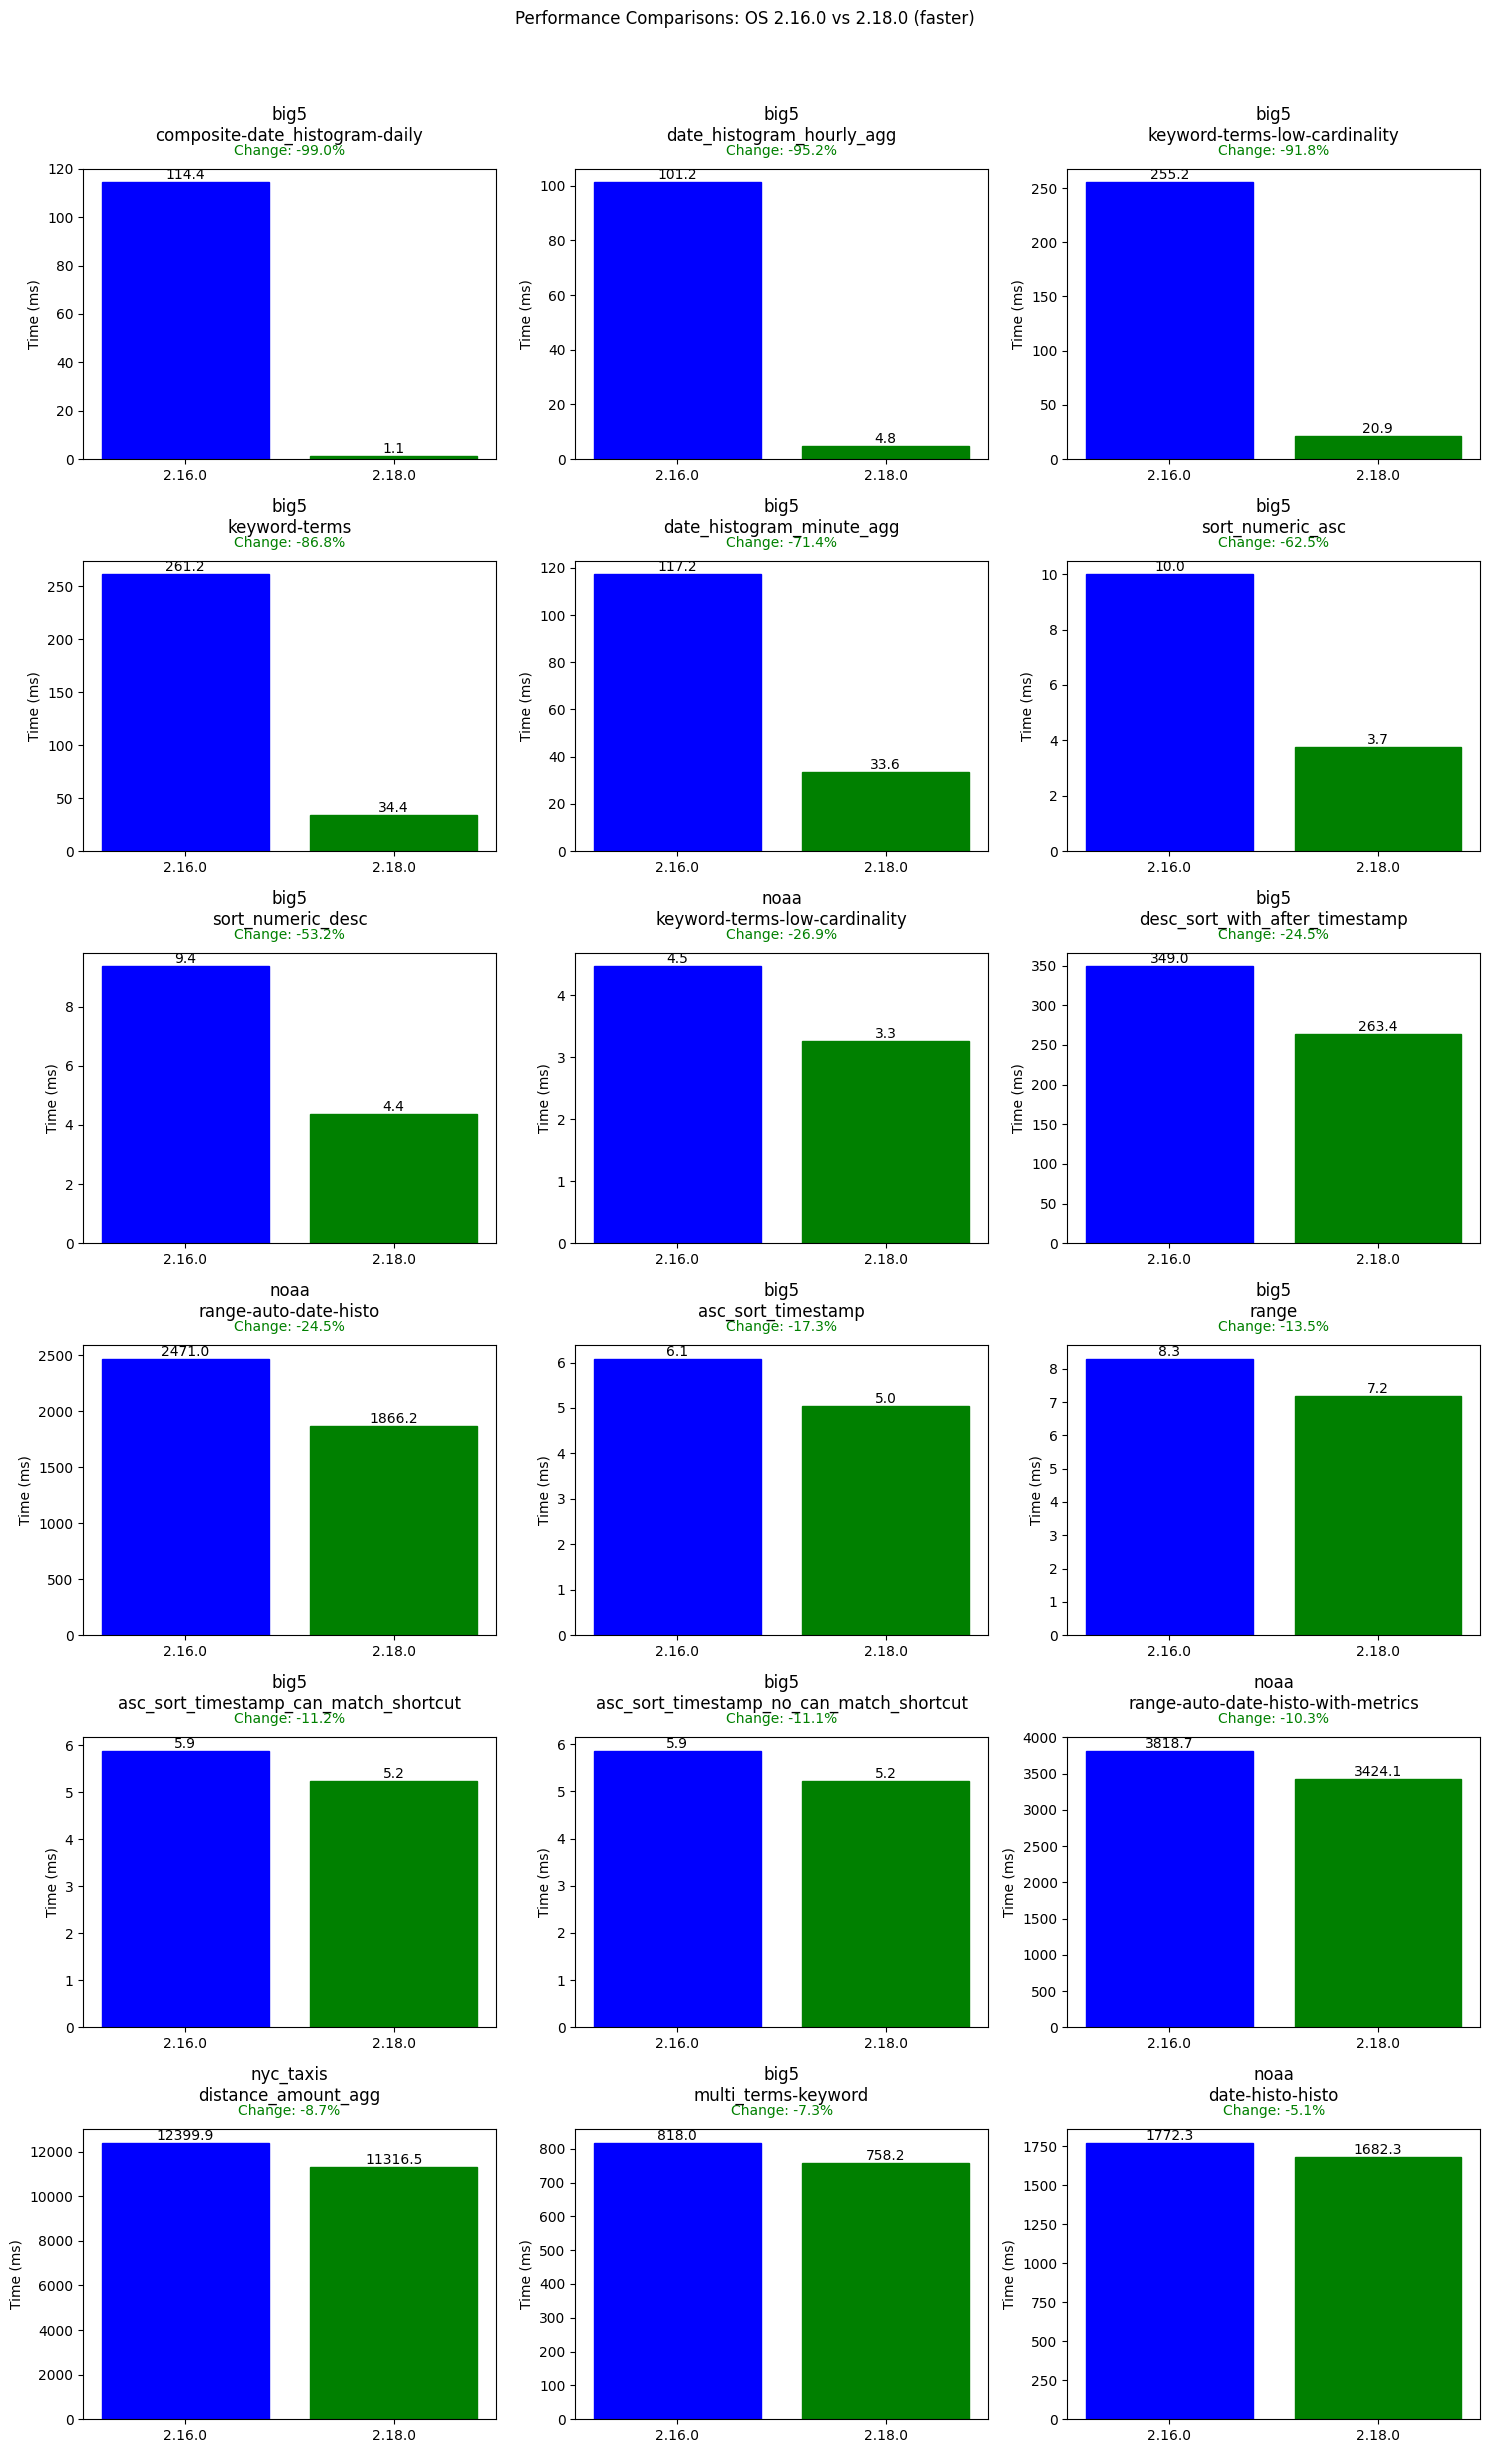

In [10]:
print("\nDETAILED BREAKDOWN")
print("=================")
print(f"\nFASTER in 2.18.0:")
print("------------------------------------------")
faster = results_df[results_df['change_percent'] < -5]  # More than 5% faster
print_details(faster, "faster")


SLOWER in 2.18.0:
------------------------------------------

Workload: big5
Category: Sorting
Operation: desc_sort_timestamp
Time change: 4.620ms → 52.148ms
Improvement: -1028.7% slower

Workload: big5
Category: Range Queries
Operation: keyword-in-range
Time change: 12.103ms → 63.182ms
Improvement: -422.0% slower

Workload: big5
Category: Sorting
Operation: desc_sort_timestamp_no_can_match_shortcut
Time change: 3.994ms → 11.964ms
Improvement: -199.5% slower

Workload: big5
Category: Sorting
Operation: desc_sort_timestamp_can_match_shortcut
Time change: 4.002ms → 11.946ms
Improvement: -198.5% slower

Workload: pmc
Category: General Operations
Operation: scroll
Time change: 366.088ms → 621.054ms
Improvement: -69.6% slower

Workload: pmc
Category: Text Querying
Operation: term
Time change: 3.194ms → 4.199ms
Improvement: -31.5% slower

Workload: pmc
Category: General Operations
Operation: default
Time change: 2.761ms → 3.511ms
Improvement: -27.2% slower

Workload: big5
Category: General 

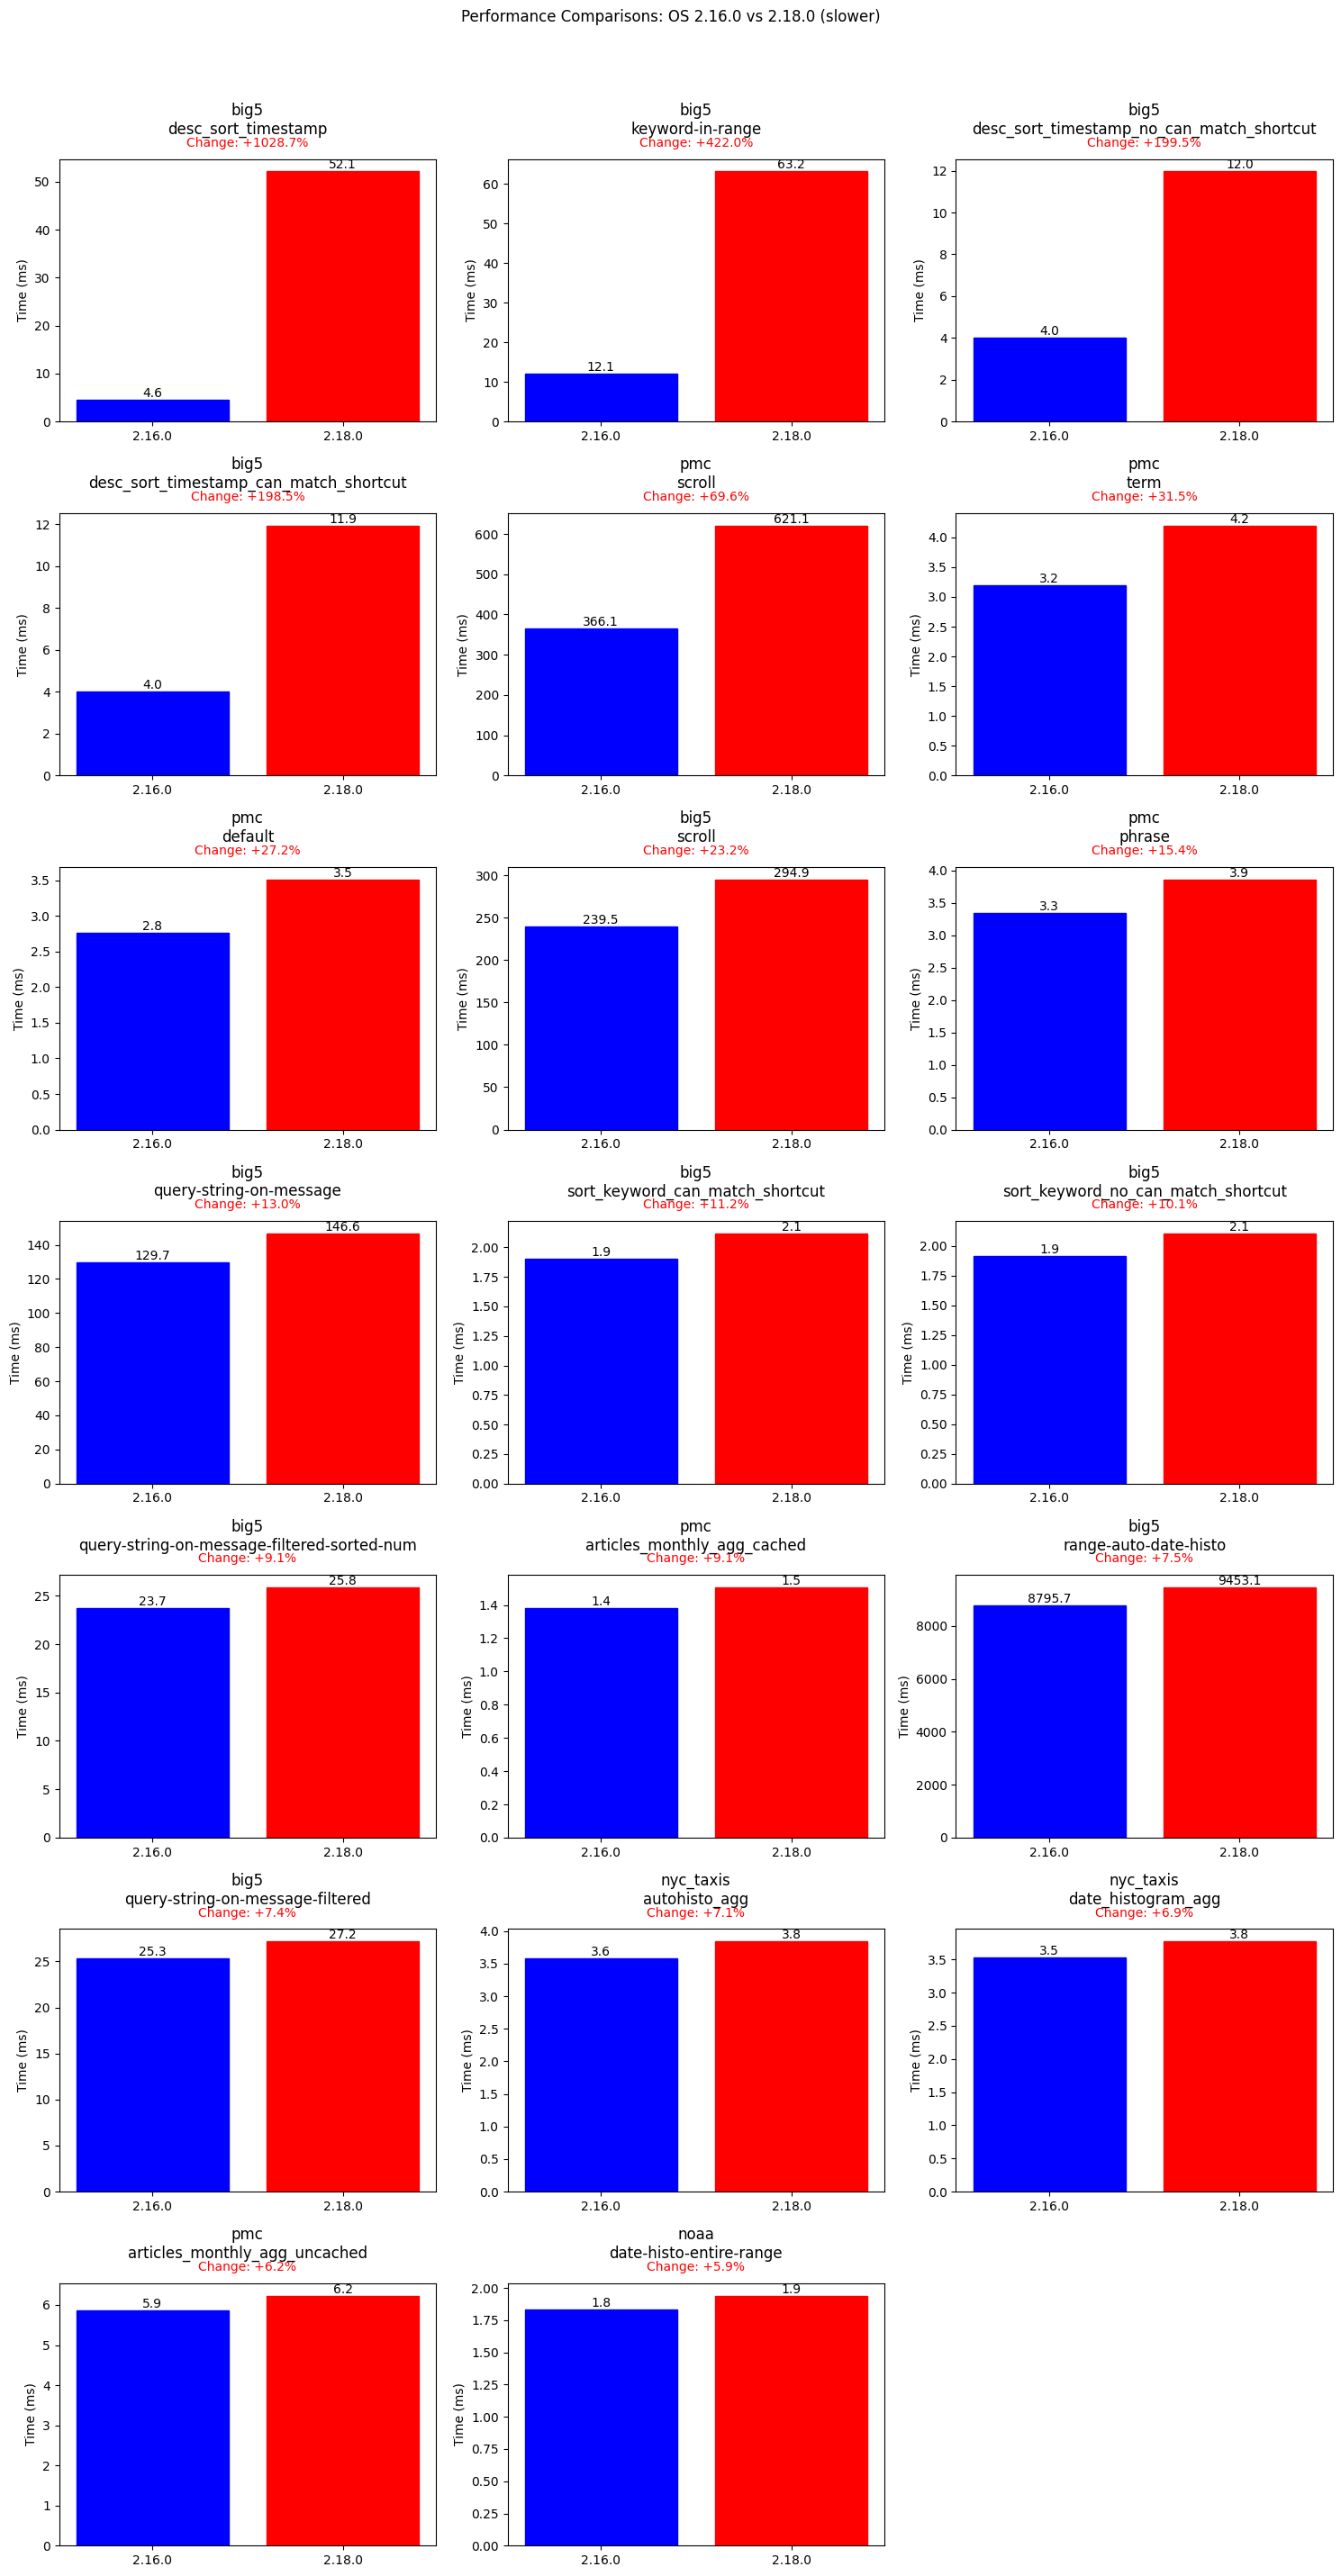

In [11]:
print(f"\nSLOWER in 2.18.0:")
print("------------------------------------------")
slower = results_df[results_df['change_percent'] > 5]  # More than 5% slower
slower = slower.sort_values('change_percent', ascending=False)
print_details(slower, "slower")


SIMILAR PERFORMANCE (within ±5%):
--------------------------------

Workload: noaa
Category: Range & Date Histogram
Operation: range-date-histo
Time change: 1651.938ms → 1576.934ms
Improvement: 4.5% 

Workload: big5
Category: Term Aggregations
Operation: cardinality-agg-high
Time change: 2445.150ms → 2334.328ms
Improvement: 4.5% 

Workload: noaa
Category: Date Histogram
Operation: date-histo-string-terms-via-default-strategy
Time change: 2575.524ms → 2464.668ms
Improvement: 4.3% 

Workload: noaa
Category: Date Histogram
Operation: date-histo-string-terms-via-global-ords
Time change: 2575.148ms → 2468.871ms
Improvement: 4.1% 

Workload: noaa
Category: Term Aggregations
Operation: keyword-terms-low-cardinality-min
Time change: 1573.675ms → 1509.236ms
Improvement: 4.1% 

Workload: noaa
Category: Date Histogram
Operation: date-histo-numeric-terms
Time change: 2242.771ms → 2152.639ms
Improvement: 4.0% 

Workload: noaa
Category: Range & Date Histogram
Operation: range-date-histo-with-metric

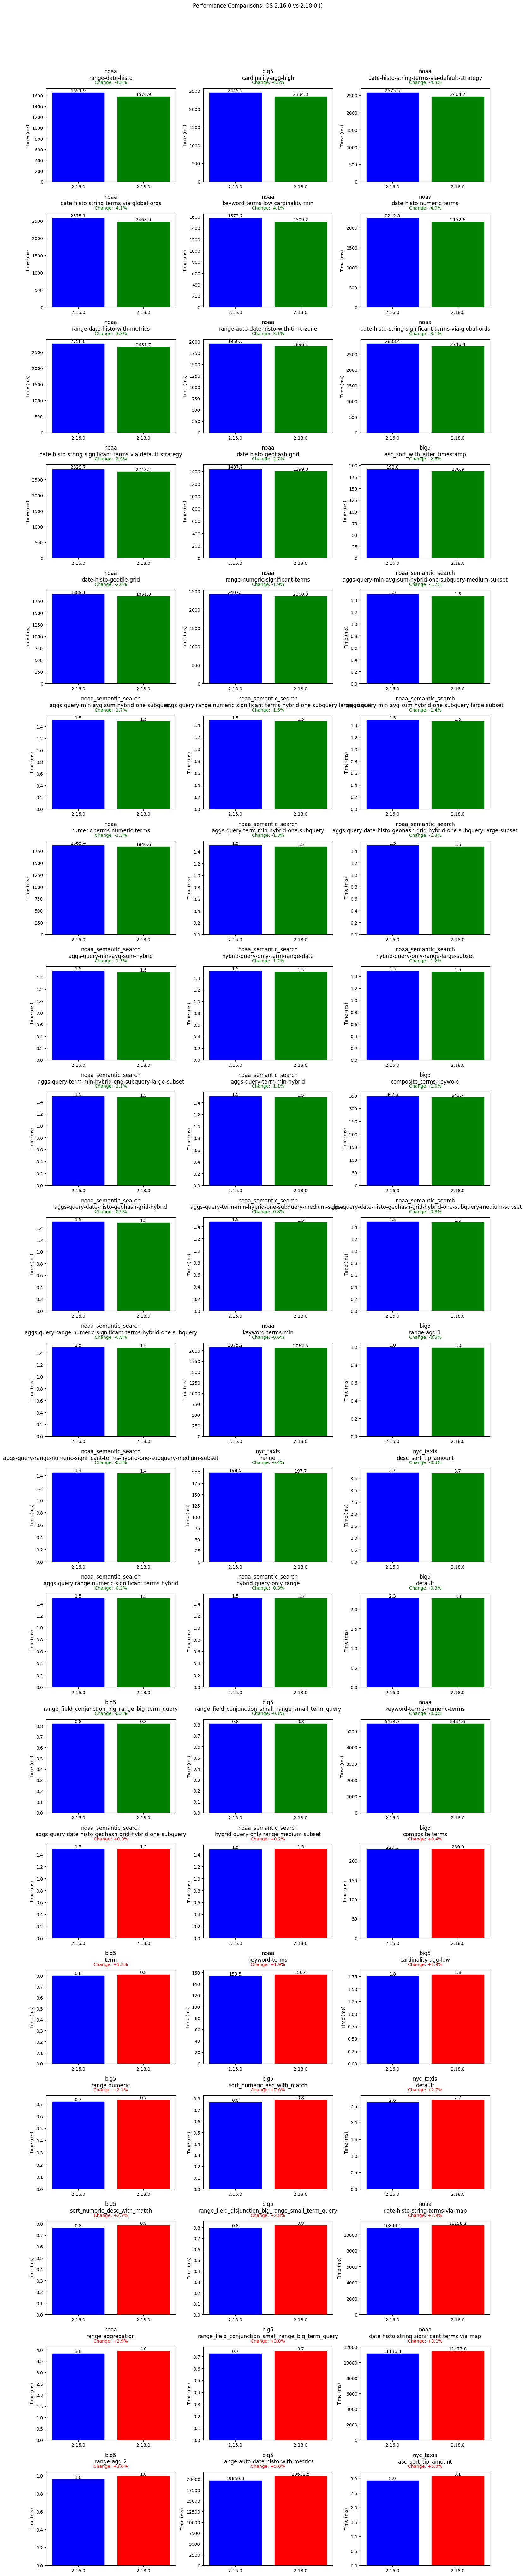

In [12]:
print(f"\nSIMILAR PERFORMANCE (within ±5%):")
print("--------------------------------")
similar = results_df[abs(results_df['change_percent']) <= 5]
print_details(similar, "")